### Download celeba from zip file

In [2]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = 'data/celeba_256/images/archive.zip'

# Determine the extraction directory (same as the ZIP file's location)
extraction_directory = os.path.dirname(zip_file_path)

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_directory)

print("Extraction complete.")


Extraction complete.


### Tensorboard Viewing

In [3]:
!cd checkpoints/
!tensorboard --logdir ./

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Check out Pre-trained VAE

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
from models import vae
plt.style.use('dark_background')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28))

In [5]:
net = vae.VAE()
net.load_state_dict(torch.load('models/weights/vae_epoch_25.pth'))

<All keys matched successfully>

In [8]:
im0 = datasets.MNIST(root='data', train=True, download=True).data[0].float()
im1 = datasets.MNIST(root='data', train=True).data[1].float()
im2 = datasets.MNIST(root='data', train=True).data[2].float()

100%|██████████| 9912422/9912422 [00:00<00:00, 104470510.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42488843.85it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34199331.41it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8082532.36it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



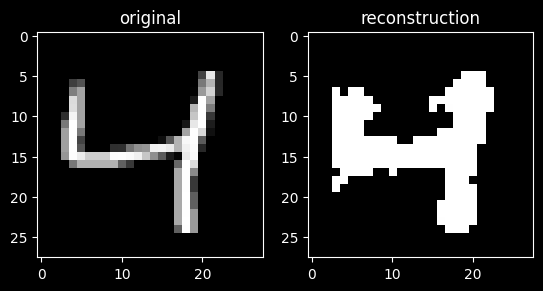

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(im2, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(im2_reconstructed, cmap='gray')
plt.title('reconstruction')
plt.show()

In [12]:
(mu0, logvar0) = net.encode(im0.reshape(-1, 784))
(mu1, logvar1) = net.encode(im1.reshape(-1, 784))
(mu2, logvar2) = net.encode(im2.reshape(-1, 784))

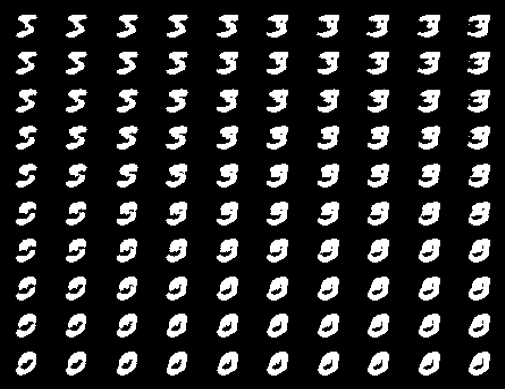

In [13]:
R, C = 10, 10
i = 0
for r, w1 in enumerate(np.linspace(0, 1, 10)):
    for c, w2 in enumerate(np.linspace(0, 1, 10)):
        plt.subplot(R, C, i + 1)
        plt.imshow(to_im(net.decode(mu0 + w1 * mu1 + w2 * mu2)), cmap='gray')
        plt.axis('off')
        i += 1
plt.show()

# Viewing Tensorboard Results

## First Experiment: Skip Factors with NI1000

##### Iterate over csv files and synthesize into one dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

##### Old synthesize dataset

In [2]:
# OLD SYNTHESIZE DATASET

import os
import csv
import re

def synthesize_data(directory_path):
    output_file = 'results/inference_results_ni1000.csv'
    
    with open(output_file, mode='w', newline='') as file_out:
        writer = csv.writer(file_out)
        # Update the header row to include teacher_timesteps and student_timesteps instead of experiment
        writer.writerow(['step', 'fid', 'skip_factor', 'dataset', 'teacher_timesteps', 'student_timesteps'])
        
        for filename in os.listdir(directory_path):
            if filename.endswith('.csv'):
                # Extract skip_factor and dataset from the filename
                skip_factor_match = re.search(r'_sf(\d+)_', filename)
                dataset_match = re.search(r'run-(.+?)_exp', filename)
                # Extract teacher_timesteps and student_timesteps
                timesteps_match = re.search(r'_exp_(\d+)_(\d+)_', filename)
                
                skip_factor = skip_factor_match.group(1) if skip_factor_match else 'nan'
                dataset = dataset_match.group(1) if dataset_match else 'Unknown'
                
                # Extract or default to 'nan' if not present
                teacher_timesteps, student_timesteps = timesteps_match.groups() if timesteps_match else ('nan', 'nan')
                
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, mode='r') as file_in:
                    reader = csv.DictReader(file_in)
                    for row in reader:
                        writer.writerow([row['Step'], row['Value'], skip_factor, dataset, teacher_timesteps, student_timesteps])

directory_path = 'results/raw_results/'
synthesize_data(directory_path)


In [3]:
import pandas as pd
df = pd.read_csv('results/inference_results_ni1000.csv')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def pivot_df(df):
    df = df.pivot(index='skip_factor', columns='step', values='fid')
    for column in df.columns:
        if column == 'skip_factor':
            df[column] = df[column].astype(int)
        else:
            df[column] = df[column].round(2)
    df = df.fillna('')
    return df

def plot_fid_by_step_and_skip_factor(df, dataset_name, best_run=False, df_name_to_save_prefix='rearranged'):
    # Filter the DataFrame for the specified dataset
    df = df[df['dataset'] == dataset_name]
    
    # Order the DataFrame by 'skip_factor' and then by 'step'
    condition = ((df['step'] == df['student_timesteps']) |
                 ((df['step'] == 1024) & 
                  (np.isnan(df['teacher_timesteps'])) & 
                  (np.isnan(df['student_timesteps']))))

    df = df[condition]
    df = df.sort_values(by=['skip_factor', 'step'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    skip_factors = df['skip_factor'].dropna().round().astype(int).unique()

    # pivot_df(df).to_csv(f'results/{df_name_to_save_prefix}_{dataset_name}.csv')
    if best_run:
        # Explicitly initialize an empty DataFrame
        min_fid_df = pd.DataFrame()
        
        for skip_factor in skip_factors:
            skip_df = df[(df['skip_factor'].isna()) | (df['skip_factor'] == skip_factor)]
            
            df_filled = skip_df.fillna({'teacher_timesteps': 'missing', 'student_timesteps': 'missing', 'skip_factor': 'missing'})
            
            idx = df_filled.groupby(['teacher_timesteps', 'student_timesteps', 'skip_factor'])['fid'].idxmin()
            
            min_fid_df = pd.concat([min_fid_df, df.loc[idx]])

        sorted_min_fid_df = min_fid_df.sort_values(by=['skip_factor', 'step'])
        for skip_factor in skip_factors:
            filtered_df = sorted_min_fid_df[(sorted_min_fid_df['skip_factor'].isna()) | (sorted_min_fid_df['skip_factor'] == skip_factor)]
            if not filtered_df.empty:
                plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='x', linestyle='-', linewidth=1, label=f'Skip Factor {skip_factor}')
    else:
        for skip_factor in skip_factors:
            skip_df = df[(df['skip_factor'].isna()) | (df['skip_factor'] == skip_factor)]
            filtered_df = skip_df[
                (skip_df['teacher_timesteps'].isna() & skip_df['student_timesteps'].isna())
                | (skip_df['step'] == skip_df['student_timesteps'])
            ]
            if not filtered_df.empty:
                plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='x', linestyle='-', linewidth=1, label=f'Skip Factor {skip_factor}')
    
    if not df.empty:
        min_step, max_step = np.log2(df['step'].min()), np.log2(df['step'].max())
        plt.xticks(np.arange(min_step, max_step + 1, 1), labels=[str(int(2**x)) for x in np.arange(min_step, max_step + 1, 1)])
    
    plt.title(f'FID Score by Step for {dataset_name.upper()} Dataset')
    plt.xlabel('Step (Log2 Scale)')
    plt.ylabel('FID Score')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    plt.show()


In [12]:
plt.style.use('default')

In [18]:
df = pd.read_csv('results/all_inference_results_w_scheduling.csv')
df = df[df['scheduling_strategy'] == 'default']
df = df[df['num_iters'] == 1000]

In [19]:
df

,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps,num_iters,scheduling_strategy
15,4,323.330566,2.0,mnist,256.0,128.0,1000,default
16,32,313.031555,2.0,mnist,256.0,128.0,1000,default
17,64,310.789520,2.0,mnist,256.0,128.0,1000,default
18,128,225.484024,2.0,mnist,256.0,128.0,1000,default
23,4,323.849854,2.0,mnist,512.0,256.0,1000,default
...,...,...,...,...,...,...,...,...
536,2,214.960266,16.0,cifar10,64.0,4.0,1000,default
537,4,236.719162,16.0,cifar10,64.0,4.0,1000,default
542,1,318.851593,16.0,mnist,64.0,4.0,1000,default
543,2,317.745972,16.0,mnist,64.0,4.0,1000,default


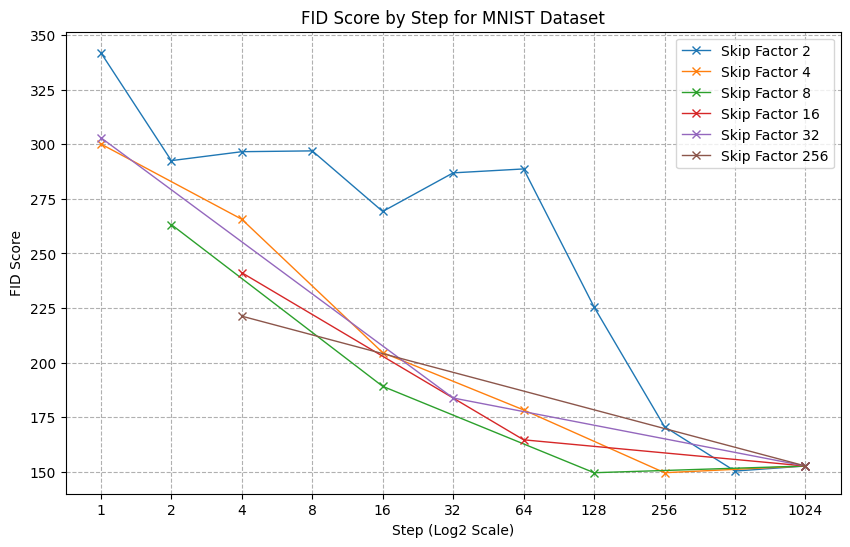

In [20]:
plot_fid_by_step_and_skip_factor(df, 'mnist')

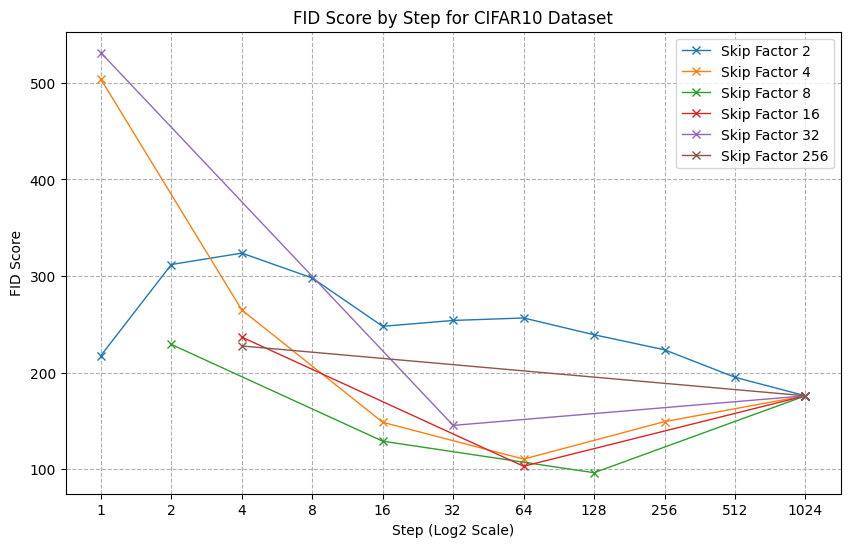

In [21]:
plot_fid_by_step_and_skip_factor(df, 'cifar10')

#### To Latex Table w Pivotted dataframe

In [57]:
df_pivot_mnist = pd.read_csv('results/rearranged_mnist.csv').fillna('')
df_pivot_mnist

,skip_factor,1,2,4,8,16,32,64,128,256,512,1024
0,,,,,,,,,,,,152.7
1,2.0,341.87,292.48,296.57,296.94,269.21,286.88,288.67,225.48,170.69,150.38,
2,4.0,300.1,,265.65,,204.59,,178.37,,149.62,,
3,8.0,,263.21,,,189.16,,,149.62,,,
4,16.0,,,241.18,,,,164.68,,,,
5,32.0,302.98,,,,,183.82,,,,,
6,256.0,,,221.29,,,,,,,,


In [55]:
df_pivot_mnist = pd.read_csv('results/rearranged_cifar10.csv').fillna('')
df_pivot_mnist

,skip_factor,1,2,4,8,16,32,64,128,256,512,1024
0,,,,,,,,,,,,175.92
1,2.0,217.53,311.88,323.68,297.91,247.86,253.96,256.5,239.14,223.56,195.11,
2,4.0,503.83,,264.84,,148.48,,110.36,,149.18,,
3,8.0,,229.12,,,128.93,,,96.26,,,
4,16.0,,,236.72,,,,102.97,,,,
5,32.0,531.19,,,,,145.26,,,,,
6,256.0,,,227.52,,,,,,,,


## Second Experiment: SF2 with NI1000, NI500,  NI128, NI32

In [115]:
import os
import csv
import re

def synthesize_data(directory_path, output_file):
    
    with open(output_file, mode='w', newline='') as file_out:
        writer = csv.writer(file_out)
        # Updated header row to include new fields
        writer.writerow(['step', 'fid', 'skip_factor', 'dataset', 'teacher_timesteps', 'student_timesteps', 'num_iters', 'scheduling_strategy'])
        
        for filename in os.listdir(directory_path):
            if filename.endswith('.csv'):
                # Extract skip_factor, dataset, num_iters, and refine scheduling_strategy extraction
                skip_factor_match = re.search(r'_sf(\d+)_', filename)
                dataset_match = re.search(r'run-(.+?)_exp', filename)
                timesteps_match = re.search(r'_exp_(\d+)_(\d+)_', filename)
                num_iters_match = re.search(r'_ni(\d+)_', filename)
                # Updated regex to capture only the substring before "_inference_"
                scheduling_strategy_match = re.search(r'_([^_]+?)_inference_', filename)
                
                skip_factor = skip_factor_match.group(1) if skip_factor_match else 'nan'
                dataset = dataset_match.group(1) if dataset_match else 'Unknown'
                teacher_timesteps, student_timesteps = timesteps_match.groups() if timesteps_match else ('nan', 'nan')
                num_iters = num_iters_match.group(1) if num_iters_match else '1000'
                # Use captured substring or default to 'default'
                scheduling_strategy = scheduling_strategy_match.group(1) if scheduling_strategy_match else 'default'
                
                # Correct scheduling_strategy if it is 'teacher', starts with 'sf', or starts with 'ni'
                if scheduling_strategy == 'teacher' or re.match(r'sf\d+', scheduling_strategy) or re.match(r'ni\d+', scheduling_strategy):
                    scheduling_strategy = 'default'
                
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, mode='r') as file_in:
                    reader = csv.DictReader(file_in)
                    for row in reader:
                        writer.writerow([row['Step'], row['Value'], skip_factor, dataset, teacher_timesteps, student_timesteps, num_iters, scheduling_strategy])

directory_path = 'results/raw_results/'
output_file = 'results/all_inference_results_w_scheduling.csv'
synthesize_data(directory_path, output_file)


In [116]:
import pandas as pd
df = pd.read_csv('results/all_inference_results_w_scheduling.csv')

In [117]:
ni_df = df[df['scheduling_strategy'] == 'default']


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def pivot_df(df):
    df = df.pivot(index='skip_factor', columns='step', values='fid')
    for column in df.columns:
        if column == 'skip_factor':
            df[column] = df[column].astype(int)
        else:
            df[column] = df[column].round(2)
    df = df.fillna('')
    return df

def plot_fid_by_step_and_num_iters(df, dataset_name, best_run=False, df_name_to_save_prefix='ni_rearranged', skip_factors=None):
    # Filter the DataFrame for the specified dataset
    df = df[df['dataset'] == dataset_name]

    condition = ((df['step'] == df['student_timesteps']) |
                 ((df['step'] == 1024) & 
                  (np.isnan(df['teacher_timesteps'])) & 
                  (np.isnan(df['student_timesteps']))))
    df = df[condition]

    
    # Order the DataFrame by 'num_iters' and then by 'step'
    df = df.sort_values(by=['num_iters', 'step'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    # Here we assume 'num_iters' is a column in your DataFrame. Adjust if necessary.
    num_iters_values = df['num_iters'].dropna().round().astype(int).unique()
    # also want to include the nan original teacher runs
    df = df[df['skip_factor'].isin(skip_factors) | pd.isnull(df['skip_factor'])]

    for num_iters in num_iters_values:
        iters_df = df[(df['num_iters'] == num_iters) | df['teacher_timesteps'].isna()]
        
        # Ensure we only plot rows relevant to the current num_iters, similar to your skip_factor logic
        filtered_df = iters_df[
            (iters_df['teacher_timesteps'].isna() & iters_df['student_timesteps'].isna())
            | (iters_df['step'] == iters_df['student_timesteps'])
        ]
        
        if not filtered_df.empty:
            plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='x', linestyle='-', linewidth=1, label=f'Num Iters {num_iters}')
    
    if not df.empty:
        min_step, max_step = np.log2(df['step'].min()), np.log2(df['step'].max())
        plt.xticks(np.arange(min_step, max_step + 1, 1), labels=[str(int(2**x)) for x in np.arange(min_step, max_step + 1, 1)])
    
    plt.title(f'FID Score by Step for {dataset_name.upper()} Dataset')
    plt.xlabel('Step (Log2 Scale)')
    plt.ylabel('FID Score')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    plt.show()

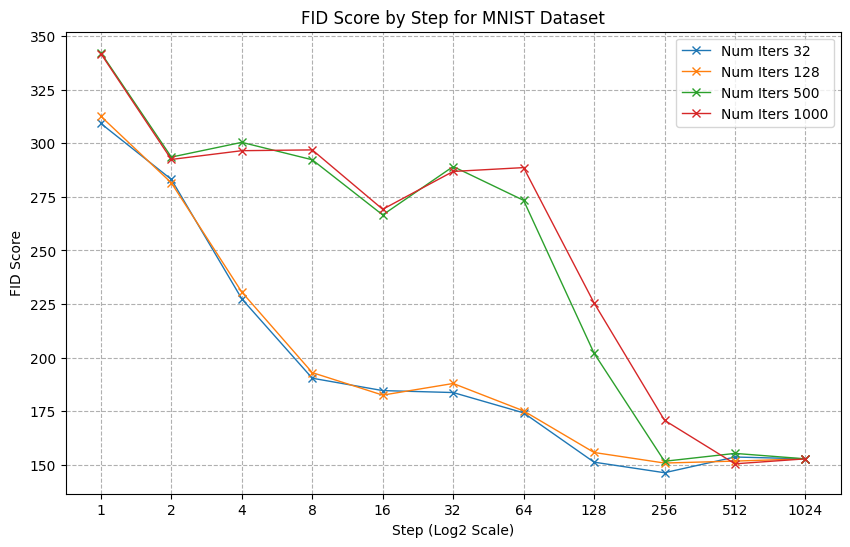

In [122]:
plot_fid_by_step_and_num_iters(ni_df, 'mnist', df_name_to_save_prefix='sf2_ni_rearranged', skip_factors=[2])

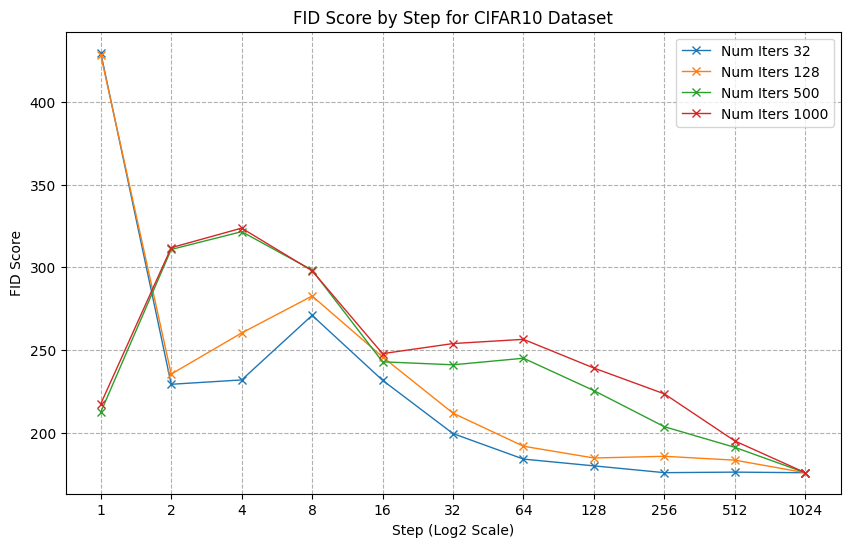

In [123]:
plot_fid_by_step_and_num_iters(ni_df, 'cifar10', df_name_to_save_prefix='sf2_ni_rearranged', skip_factors=[2])#

## Scheduled Experiments, NI1000

In [27]:
import os
import csv
import re

def synthesize_data(directory_path, output_file):
    
    with open(output_file, mode='w', newline='') as file_out:
        writer = csv.writer(file_out)
        # Updated header row to include new fields
        writer.writerow(['step', 'fid', 'skip_factor', 'dataset', 'teacher_timesteps', 'student_timesteps', 'num_iters', 'scheduling_strategy'])
        
        for filename in os.listdir(directory_path):
            if filename.endswith('.csv'):
                # Extract skip_factor, dataset, num_iters, and refine scheduling_strategy extraction
                skip_factor_match = re.search(r'_sf(\d+)_', filename)
                dataset_match = re.search(r'run-(.+?)_exp', filename)
                timesteps_match = re.search(r'_exp_(\d+)_(\d+)_', filename)
                num_iters_match = re.search(r'_ni(\d+)_', filename)
                # Updated regex to capture only the substring before "_inference_"
                scheduling_strategy_match = re.search(r'_([^_]+?)_inference_', filename)
                
                skip_factor = skip_factor_match.group(1) if skip_factor_match else 'nan'
                dataset = dataset_match.group(1) if dataset_match else 'Unknown'
                teacher_timesteps, student_timesteps = timesteps_match.groups() if timesteps_match else ('nan', 'nan')
                num_iters = num_iters_match.group(1) if num_iters_match else '1000'
                # Use captured substring or default to 'default'
                scheduling_strategy = scheduling_strategy_match.group(1) if scheduling_strategy_match else 'default'
                
                # Correct scheduling_strategy if it is 'teacher', starts with 'sf', or starts with 'ni'
                if scheduling_strategy == 'teacher' or re.match(r'sf\d+', scheduling_strategy) or re.match(r'ni\d+', scheduling_strategy):
                    scheduling_strategy = 'default'
                
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, mode='r') as file_in:
                    reader = csv.DictReader(file_in)
                    for row in reader:
                        writer.writerow([row['Step'], row['Value'], skip_factor, dataset, teacher_timesteps, student_timesteps, num_iters, scheduling_strategy])

directory_path = 'results/raw_results/'
output_file = 'results/all_inference_results_w_scheduling.csv'
synthesize_data(directory_path, output_file)


In [87]:
df = pd.read_csv('results/all_inference_results_w_scheduling.csv')
df

,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps,num_iters,scheduling_strategy
0,1,463.677368,2.0,cifar10,2.0,1.0,1000,nefvlf
1,1,322.562744,2.0,mnist,16.0,8.0,32,default
2,2,317.059357,2.0,mnist,16.0,8.0,32,default
3,4,311.998932,2.0,mnist,16.0,8.0,32,default
4,8,190.339920,2.0,mnist,16.0,8.0,32,default
...,...,...,...,...,...,...,...,...
472,32,316.172028,8.0,mnist,1024.0,128.0,1000,lf
473,128,153.077423,8.0,mnist,1024.0,128.0,1000,lf
474,1,318.851593,16.0,mnist,64.0,4.0,1000,default
475,2,317.745972,16.0,mnist,64.0,4.0,1000,default


In [89]:
sch_df = df[(df['scheduling_strategy'] != 'default') | df['teacher_timesteps'].isna()]
sch_df

,step,fid,skip_factor,dataset,teacher_timesteps,student_timesteps,num_iters,scheduling_strategy
0,1,463.677368,2.0,cifar10,2.0,1.0,1000,nefvlf
9,1,309.306946,8.0,mnist,8.0,1.0,1000,ef
14,1,309.318665,2.0,mnist,2.0,1.0,1000,nefvlf
29,1,209.011841,2.0,cifar10,8.0,4.0,1000,nefvlf
30,2,216.693329,2.0,cifar10,8.0,4.0,1000,nefvlf
...,...,...,...,...,...,...,...,...
464,1,316.192169,32.0,mnist,32.0,1.0,1000,vefnlf
470,4,324.125031,8.0,mnist,1024.0,128.0,1000,lf
471,16,322.492249,8.0,mnist,1024.0,128.0,1000,lf
472,32,316.172028,8.0,mnist,1024.0,128.0,1000,lf


In [44]:
sch_df['scheduling_strategy'].unique()

array(['nefvlf', 'ef', 'l', 'vefnlf', 'lf'], dtype=object)

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def pivot_df(df):
    df = df.pivot(index='skip_factor', columns='step', values='fid')
    for column in df.columns:
        if column == 'skip_factor':
            df[column] = df[column].astype(int)
        else:
            df[column] = df[column].round(2)
    df = df.fillna('')
    return df

def plot_fid_by_step_and_sch_str(df, dataset_name):
    # Filter the DataFrame for the specified dataset
    df = df[df['dataset'] == dataset_name]

    condition = ((df['step'] == df['student_timesteps']) |
                 ((df['step'] == 1024) & 
                  (np.isnan(df['teacher_timesteps'])) & 
                  (np.isnan(df['student_timesteps']))))
    df = df[condition]
    
    # Order the DataFrame by 'num_iters' and then by 'step'
    df = df.sort_values(by=['num_iters', 'step'])
    
    # Plotting
    plt.figure(figsize=(10, 6))

    # Here we assume 'num_iters' is a column in your DataFrame. Adjust if necessary.
    sch_str_values = df['scheduling_strategy'].dropna().unique()
    sch_str_values = sch_str_values[sch_str_values != 'default']
    print(sch_str_values)
    for sch_str in sch_str_values:
        iters_df = df[(df['scheduling_strategy'] == sch_str) | (df['teacher_timesteps'].isna())]
        
        # Ensure we only plot rows relevant to the current num_iters, similar to your skip_factor logic
        filtered_df = iters_df[
            (iters_df['teacher_timesteps'].isna() & iters_df['student_timesteps'].isna())
            | (iters_df['step'] == iters_df['student_timesteps'])
        ]
        
        if not filtered_df.empty:
            plt.plot(np.log2(filtered_df['step']), filtered_df['fid'], marker='x', linestyle='-', linewidth=1, label=f'Sch Str {sch_str}')
    
    if not df.empty:
        min_step, max_step = np.log2(df['step'].min()), np.log2(df['step'].max())
        plt.xticks(np.arange(min_step, max_step + 1, 1), labels=[str(int(2**x)) for x in np.arange(min_step, max_step + 1, 1)])
    
    plt.title(f'FID Score by Step for {dataset_name.upper()} Dataset')
    plt.xlabel('Step (Log2 Scale)')
    plt.ylabel('FID Score')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    plt.show()

['ef' 'nefvlf' 'l' 'lf' 'vefnlf']


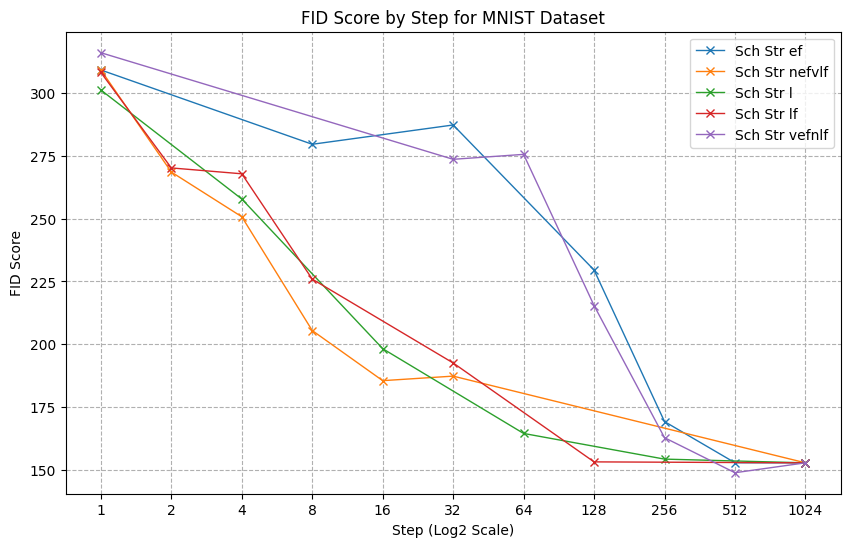

In [108]:
plot_fid_by_step_and_sch_str(sch_df, 'mnist')

['nefvlf' 'vefnlf' 'ef' 'l' 'lf']


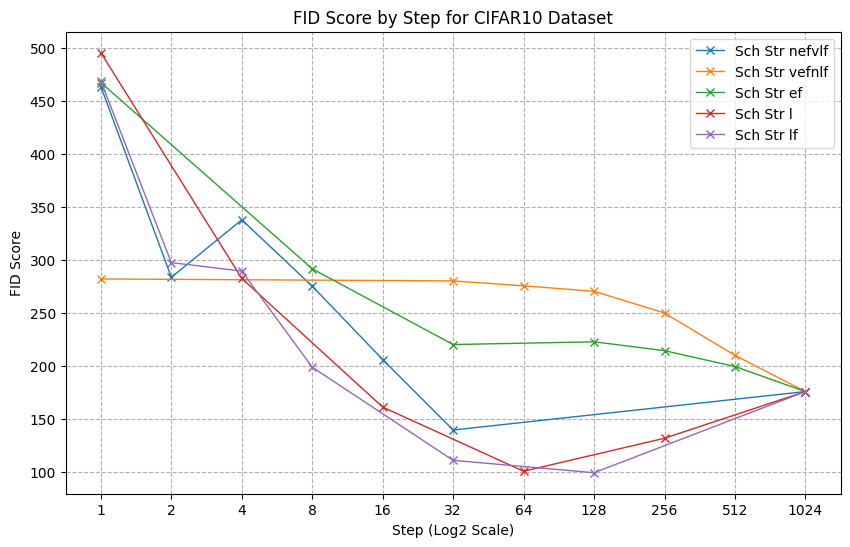

In [109]:
plot_fid_by_step_and_sch_str(sch_df, 'cifar10')

## Extract Celeba U Zip

In [147]:
from tqdm import tqdm

In [146]:
import zipfile
import os

zip_path = 'data/celeba_256/archive.zip'
extraction_path = 'data/celeba_256/extracted/'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extracted contents of '{zip_path}' to '{extraction_path}'")


Extracted contents of 'data/celeba_256/archive.zip' to 'data/celeba_256/extracted/'


In [148]:
from tqdm import tqdm
import zipfile
import os

zip_path = 'data/celeba_256/celeba_256.zip'
extraction_path = 'data/celeba_256/extracted/'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get the list of files names inside the zip
    file_names = zip_ref.namelist()
    # Set up tqdm progress bar
    with tqdm(total=len(file_names), desc="Extracting files") as progress_bar:
        for file in file_names:
            zip_ref.extract(member=file, path=extraction_path)
            # Update the progress bar
            progress_bar.update(1)

print(f"Extracted contents of '{zip_path}' to '{extraction_path}'")


Extracting files: 100%|██████████| 30000/30000 [01:55<00:00, 259.47it/s]

Extracted contents of 'data/celeba_256/celeba_256.zip' to 'data/celeba_256/extracted/'


## VAE

In [125]:
from diffusers import AutoencoderKL

url = "models/weights/vae-ft-m\qse-840000-ema-pruned.ckpt"  # can also be a local file
model = AutoencoderKL.from_single_file(url)

In [145]:
encoded_output.latent_dist.mean.shape

torch.Size([1, 4, 32, 32])

In [151]:
type(image)

torch.Tensor

In [141]:
from diffusers import AutoencoderKL
from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Load and preprocess the image
image_path = "images/portrait.png"
original_image = Image.open(image_path).convert("RGB")
preprocess = Compose([
    Resize((256, 256)),  # Adjust according to your model's input size
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
image = preprocess(original_image).unsqueeze(0)  # Add batch dimension

# Encode the image
with torch.no_grad():
    encoded_output = model.encode(image)
    latents = encoded_output.latent_dist.mean

# Decode the latents back to an image
with torch.no_grad():
    decoded_output = model.decode(latents)
    decoded_image = decoded_output.sample  # Get the decoded image tensor

# Postprocess and save the decoded image
def postprocess(tensor):
    tensor = tensor.detach().cpu().clamp_(0, 1)
    tensor = tensor.permute(1, 2, 0)  # CHW to HWC
    tensor = tensor.numpy()
    image = Image.fromarray((tensor * 255).astype('uint8'))
    return image

decoded_image_postprocessed = postprocess(decoded_image.squeeze(0))  # Remove batch dimension
decoded_image_postprocessed.save("images/decoded_portrait.png")

# Optionally display the images
# original_image.show()
# decoded_image_postprocessed.show()


encoded output
AutoencoderKLOutput(latent_dist=<diffusers.models.autoencoders.vae.DiagonalGaussianDistribution object at 0x7fb08b1ebdd0>)



encoded output shape



encoded_output.latent_dist



encoded_output.latent_dist.shape



encoded_output.latent_dist.mean
tensor([[[[ 11.7753,   5.8140,  -6.7199,  ...,  16.9647,  13.7682,   5.6951],
          [  0.0833,  -1.7784,   1.3369,  ...,   3.9076,   8.7730,   1.4093],
          [ -5.8270,   0.8467,   0.5445,  ...,   6.8074,  -0.6207,  -0.3020],
          ...,
          [  4.7856,   2.3558,   3.9598,  ...,  -2.5077,  -4.5085,  -0.0420],
          [  8.7203,   4.9508,  -0.3588,  ...,   6.6188,  -0.4116,   3.7011],
          [  2.8851,   7.2721,   7.9167,  ...,   3.7776,   4.4908,  10.3536]],

         [[ 14.5070,   1.1312,   4.4756,  ...,  11.4720,  16.9771,  11.1826],
          [  5.5928,   6.3245,   2.3681,  ...,   7.5703,   1.8245,  -1.6385],
          [ -1.9096,   5.9610,  -3.4417,  ...,   2.5181,   2.8041,  -4.9659],
          ...,
   

In [ ]:
modify my code so that the dataset loading uses a pretrained VAE if specified, as by the arguments args.use_vae and args.vae_name.

If the vae is specified to be used, then we must load it and perform image encoding/decoding with it, before the diffusion model training can happen in the latent space. I am attaching relevant files of the pipeline below, including some sample code for you to see how to load the vae, encode it, and decode it. 